# Generate Semi-Synthetic Causal Survival Data from MIMIC IV

In [1]:
# This implementation is largely derived from the reference implementation at:
# https://github.com/tomer1812/pydts
# (MIT License — see original repository for full licensing information)

MIMIC IV is available at:
* https://physionet.org/content/mimiciv/2.0/
* Access requires registration and agreement to the data use agreement.

This code is used to set up the MIMIC IV dataset for further analysis in our SurvHTE Benchmark.

In [2]:
# Directory for MIMIC IV data
# This directory should contain the MIMIC IV dataset files as per the structure provided by Physionet

mimic_data_dir = 'physionet.org/files/mimiciv/2.0'

## Constants for MIMIC Tables

In [3]:
ADMISSION_TIME_COL = 'admittime'
DISCHARGE_TIME_COL = 'dischtime'
DEATH_TIME_COL = 'deathtime'
ED_REG_TIME = 'edregtime'
ED_OUT_TIME = 'edouttime'
AGE_COL = 'anchor_age'
GENDER_COL = 'gender'

AGE_BINS = list(range(0, 125, 5))
AGE_LABELS = [f'{AGE_BINS[a]}' for a in range(len(AGE_BINS) - 1)]

YEAR_GROUP_COL = 'anchor_year_group'
SUBSET_YEAR_GROUP = '2017 - 2019'
SUBJECT_ID_COL = 'subject_id'
ADMISSION_ID_COL = 'hadm_id'
ADMISSION_TYPE_COL = 'admission_type'
CHART_TIME_COL = 'charttime'
STORE_TIME_COL = 'storetime'
LOS_EXACT_COL = 'LOS exact'
LOS_DAYS_COL = 'LOS days'
ADMISSION_LOCATION_COL = 'admission_location'
DISCHARGE_LOCATION_COL = 'discharge_location'
RACE_COL = 'race'
INSURANCE_COL = 'insurance'
ADMISSION_TO_RESULT_COL = 'admission_to_result_time'
ADMISSION_AGE_COL = 'admission_age'
ADMISSION_YEAR_COL = 'admission_year'
ADMISSION_COUNT_COL = 'admissions_count'
ITEM_ID_COL = 'itemid'
NIGHT_ADMISSION_FLAG = 'night_admission'
MARITAL_STATUS_COL = 'marital_status'
STANDARDIZED_AGE_COL = 'standardized_age'
COEF_COL = '   coef   '
STDERR_COL = ' std err '
DIRECT_IND_COL = 'direct_emrgency_flag'
PREV_ADMISSION_IND_COL = 'last_less_than_diff'
ADMISSION_COUNT_GROUP_COL = ADMISSION_COUNT_COL + '_group'

DISCHARGE_REGROUPING_DICT = {
    'HOME': 'HOME',
    'HOME HEALTH CARE': 'HOME',
    'SKILLED NURSING FACILITY': 'FURTHER TREATMENT',
    'DIED': 'DIED',
    'REHAB': 'HOME',
    'CHRONIC/LONG TERM ACUTE CARE': 'FURTHER TREATMENT',
    'HOSPICE': 'FURTHER TREATMENT',
    'AGAINST ADVICE': 'CENSORED',
    'ACUTE HOSPITAL': 'FURTHER TREATMENT',
    'PSYCH FACILITY': 'FURTHER TREATMENT',
    'OTHER FACILITY': 'FURTHER TREATMENT',
    'ASSISTED LIVING': 'HOME',
    'HEALTHCARE FACILITY': 'FURTHER TREATMENT',
}

RACE_REGROUPING_DICT = {
    'WHITE': 'WHITE',
    'UNKNOWN': 'OTHER',
    'BLACK/AFRICAN AMERICAN': 'BLACK',
    'OTHER': 'OTHER',
    'ASIAN': 'ASIAN',
    'WHITE - OTHER EUROPEAN': 'WHITE',
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC',
    'HISPANIC/LATINO - DOMINICAN': 'HISPANIC',
    'ASIAN - CHINESE': 'ASIAN',
    'BLACK/CARIBBEAN ISLAND': 'BLACK',
    'BLACK/AFRICAN': 'BLACK',
    'BLACK/CAPE VERDEAN': 'BLACK',
    'PATIENT DECLINED TO ANSWER': 'OTHER',
    'WHITE - BRAZILIAN': 'WHITE',
    'PORTUGUESE': 'HISPANIC',
    'ASIAN - SOUTH EAST ASIAN': 'ASIAN',
    'WHITE - RUSSIAN': 'WHITE',
    'ASIAN - ASIAN INDIAN': 'ASIAN',
    'WHITE - EASTERN EUROPEAN': 'WHITE',
    'AMERICAN INDIAN/ALASKA NATIVE': 'OTHER',
    'HISPANIC/LATINO - GUATEMALAN': 'HISPANIC',
    'HISPANIC/LATINO - MEXICAN': 'HISPANIC',
    'HISPANIC/LATINO - SALVADORAN': 'HISPANIC',
    'SOUTH AMERICAN': 'HISPANIC',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'OTHER',
    'HISPANIC/LATINO - COLUMBIAN': 'HISPANIC',
    'HISPANIC/LATINO - CUBAN': 'HISPANIC',
    'ASIAN - KOREAN': 'ASIAN',
    'HISPANIC/LATINO - HONDURAN': 'HISPANIC',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'HISPANIC',
    'UNABLE TO OBTAIN': 'OTHER',
    'HISPANIC OR LATINO': 'HISPANIC'
}

table_rename_columns = {
    'AnionGap': 'Anion gap',
    'Bicarbonate': 'Bicarbonate',
    'CalciumTotal': 'Calcium total',
    'Chloride': 'Chloride',
    'Creatinine': 'Creatinine',
    'Glucose': 'Glucose',
    'Magnesium': 'Magnesium',
    'Phosphate': 'Phosphate',
    'Potassium': 'Potassium',
    'Sodium': 'Sodium',
    'UreaNitrogen': 'Urea nitrogen',
    'Hematocrit': 'Hematocrit',
    'Hemoglobin': 'Hemoglobin',
    'MCH': 'MCH',
    'MCHC': 'MCHC',
    'MCV': 'MCV',
    'PlateletCount': 'Platelet count',
    'RDW': 'RDW',
    'RedBloodCells': 'Red blood cells',
    'WhiteBloodCells': 'White blood cells',
    NIGHT_ADMISSION_FLAG: 'Night admission',
    GENDER_COL: 'Sex',
    DIRECT_IND_COL: 'Direct emergency',
    PREV_ADMISSION_IND_COL: 'Previous admission this month',
    ADMISSION_AGE_COL: 'Admission age',
    INSURANCE_COL: 'Insurance',
    MARITAL_STATUS_COL: 'Marital status',
    RACE_COL: 'Race',
    ADMISSION_COUNT_GROUP_COL: 'Admissions number',
    LOS_DAYS_COL: 'LOS (days)',
    DISCHARGE_LOCATION_COL: 'Discharge location'
}

table_rename_sex = {0: 'Male', 1: 'Female'}
table_rename_race = {'ASIAN': 'Asian', 'BLACK': 'Black', 'HISPANIC': 'Hispanic', 'OTHER': 'Other',
                      'WHITE': 'White'}
table_rename_marital = {'SINGLE': 'Single', 'MARRIED': 'Married', 'DIVORCED': 'Divorced', 'WIDOWED': 'Widowed'}
table_rename_yes_no = {0: 'No', 1: 'Yes'}
table_rename_normal_abnormal = {0: 'Normal', 1: 'Abnormal'}
table_rename_discharge = {1: 'Home', 2: 'Further Treatment', 3: 'Died', 0: 'Censored'}


rename_beta_index = {
    'AdmsCount 2': 'Admissions number 2',
    'AdmsCount 3up': 'Admissions number 3+',
    'AnionGap': 'Anion gap',
    'Bicarbonate': 'Bicarbonate',
    'CalciumTotal': 'Calcium total',
    'Chloride': 'Chloride',
    'Creatinine': 'Creatinine',
    'Ethnicity BLACK': 'Ethnicity black',
    'Ethnicity HISPANIC': 'Ethnicity hispanic',
    'Ethnicity OTHER': 'Ethnicity other',
    'Ethnicity WHITE': 'Ethnicity white',
    'Glucose': 'Glucose',
    'Hematocrit': 'Hematocrit',
    'Hemoglobin': 'Hemoglobin',
    'Insurance Medicare': 'Insurance medicare',
    'Insurance Other': 'Insurance other',
    'MCH': 'MCH',
    'MCHC': 'MCHC',
    'MCV': 'MCV',
    'Magnesium': 'Magnesium',
    'Marital MARRIED': 'Marital married',
    'Marital SINGLE': 'Marital single',
    'Marital WIDOWED': 'Marital widowed',
    'Phosphate': 'Phosphate',
    'PlateletCount': 'Platelet count',
    'Potassium': 'Potassium',
    'RDW': 'RDW',
    'RedBloodCells': 'Red blood cells',
    'Sodium': 'Sodium',
    'UreaNitrogen': 'Urea nitrogen',
    'WhiteBloodCells': 'White blood cells',
    'direct emrgency flag': 'Direct emergency',
    'gender': 'Sex',
    'last less than diff': 'Recent admission',
    'night admission': 'Night admission',
    'standardized age': 'Standardized age',
}

beta_units = {
    'Admissions number 2': '2',
    'Admissions number 3+': '3+',
    'Anion gap': 'Abnormal',
    'Bicarbonate': 'Abnormal',
    'Calcium total': 'Abnormal',
    'Chloride': 'Abnormal',
    'Creatinine': 'Abnormal',
    'Ethnicity black': 'Black',
    'Ethnicity hispanic': 'Hispanic',
    'Ethnicity other': 'Other',
    'Ethnicity white': 'White',
    'Glucose': 'Abnormal',
    'Hematocrit': 'Abnormal',
    'Hemoglobin': 'Abnormal',
    'Insurance medicare': 'Medicare',
    'Insurance other': 'Other',
    'MCH': 'Abnormal',
    'MCHC': 'Abnormal',
    'MCV': 'Abnormal',
    'Magnesium': 'Abnormal',
    'Marital married': 'Married',
    'Marital single': 'Single',
    'Marital widowed': 'Widowed',
    'Phosphate': 'Abnormal',
    'Platelet count': 'Abnormal',
    'Potassium': 'Abnormal',
    'RDW': 'Abnormal',
    'Red blood cells': 'Abnormal',
    'Sodium': 'Abnormal',
    'Urea nitrogen': 'Abnormal',
    'White blood cells': 'Abnormal',
    'Direct emergency': 'Yes',
    'Sex': 'Female',
    'Recent admission': 'Yes',
    'Night admission': 'Yes',
    'Standardized age': '',
}

## Load the Cohort Data

In [4]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os

patients_file = os.path.join(mimic_data_dir, 'hosp', 'patients.csv.gz')
admissions_file = os.path.join(mimic_data_dir, 'hosp', 'admissions.csv.gz')
lab_file = os.path.join(mimic_data_dir, 'hosp', 'labevents.csv.gz')
lab_meta_file = os.path.join(mimic_data_dir, 'hosp', 'd_labitems.csv.gz')

patients_df = pd.read_csv(patients_file, compression='gzip')
COLUMNS_TO_DROP = ['dod']
patients_df.drop(COLUMNS_TO_DROP, axis=1, inplace=True)

admissions_df = pd.read_csv(admissions_file, compression='gzip', parse_dates=[ADMISSION_TIME_COL,
                                                                                DISCHARGE_TIME_COL, DEATH_TIME_COL,
                                                                                ED_REG_TIME, ED_OUT_TIME])

COLUMNS_TO_DROP = ['hospital_expire_flag', 'edouttime', 'edregtime', 'deathtime', 'language']
admissions_df.drop(COLUMNS_TO_DROP, axis=1, inplace=True)

admissions_df = admissions_df.merge(patients_df, on=[SUBJECT_ID_COL])

# Calculate Age at Admission and Group of Admission Year
# Based on mimic IV example https://mimic.mit.edu/docs/iv/modules/hosp/patients/

# Diff column first
admissions_df[ADMISSION_YEAR_COL] = (admissions_df[ADMISSION_TIME_COL].dt.year - admissions_df['anchor_year'])

# Age at admission calculation
admissions_df[ADMISSION_AGE_COL] = (admissions_df[AGE_COL] + admissions_df[ADMISSION_YEAR_COL])

# Admission year group lower bound calculation
admissions_df[ADMISSION_YEAR_COL] = admissions_df[ADMISSION_YEAR_COL] + admissions_df[YEAR_GROUP_COL].apply(
    lambda x: int(x.split(' ')[0]))

# # Calculating LOS (exact, days resolution) and night admission indicator
admissions_df[LOS_EXACT_COL] = (admissions_df[DISCHARGE_TIME_COL] - admissions_df[ADMISSION_TIME_COL])
admissions_df[NIGHT_ADMISSION_FLAG] = ((admissions_df[ADMISSION_TIME_COL].dt.hour >= 20) | \
                                        (admissions_df[ADMISSION_TIME_COL].dt.hour < 8)).values
admissions_df[LOS_DAYS_COL] = admissions_df[LOS_EXACT_COL].dt.ceil('1d')

max_clip_days = 28

# # Taking only SPECIFIC_ADMISSION_TYPE admissions from now on
SPECIFIC_ADMISSION_TYPE = ['DIRECT EMER.', 'EW EMER.']
admissions_df = admissions_df[admissions_df[ADMISSION_TYPE_COL].isin(SPECIFIC_ADMISSION_TYPE)]

# # Add direct emergency flag
admissions_df[DIRECT_IND_COL] = (admissions_df[ADMISSION_TYPE_COL] == 'DIRECT EMER.').astype(int)

# # Counting SPECIFIC_ADMISSION_TYPE admissions to each patient
number_of_admissions = admissions_df.groupby(SUBJECT_ID_COL)[ADMISSION_ID_COL].nunique()
number_of_admissions.name = ADMISSION_COUNT_COL

admissions_df = admissions_df.merge(number_of_admissions, on=SUBJECT_ID_COL)

# # Add recurrent admissions group per patient according to last admission
ADMISSION_COUNT_BINS = [1, 1.5, 2.5, 5000]
ADMISSION_COUNT_LABELS = ['1', '2', '3up']

admissions_df[ADMISSION_COUNT_GROUP_COL] = pd.cut(admissions_df[ADMISSION_COUNT_COL],
                                                    bins=ADMISSION_COUNT_BINS,
                                                    labels=ADMISSION_COUNT_LABELS,
                                                    include_lowest=True)

# # Adds last admission with previous admission in past month indicator
indicator_diff = pd.to_timedelta('30d')

tmp_admissions = admissions_df[admissions_df[ADMISSION_COUNT_COL] > 1]
ind_ser = tmp_admissions.sort_values(by=[SUBJECT_ID_COL, ADMISSION_TIME_COL]).groupby(
    SUBJECT_ID_COL).apply(
    lambda tmp_df: (tmp_df[ADMISSION_TIME_COL] - tmp_df[DISCHARGE_TIME_COL].shift(1)) <= indicator_diff)

ind_ser.index = ind_ser.index.droplevel(1)
ind_ser.name = PREV_ADMISSION_IND_COL
ind_ser = ind_ser.iloc[ind_ser.reset_index().drop_duplicates(subset=[SUBJECT_ID_COL], keep='last').index]

admissions_df = admissions_df.merge(ind_ser.astype(int), left_on=SUBJECT_ID_COL, right_index=True, how='outer')
admissions_df[PREV_ADMISSION_IND_COL].fillna(0, inplace=True)


# # Keep only last admission per patient
only_last_admission = admissions_df.sort_values(by=[ADMISSION_TIME_COL]).drop_duplicates(subset=[SUBJECT_ID_COL], keep='last')

# # Take only patients with last admission after MINIMUM YEAR
MINIMUM_YEAR = 2014
only_last_admission = only_last_admission[only_last_admission[ADMISSION_YEAR_COL] >= MINIMUM_YEAR]

pids = only_last_admission[SUBJECT_ID_COL].drop_duplicates()
adm_ids = only_last_admission[ADMISSION_ID_COL].drop_duplicates()

# # Load relevant lab tests
LOAD_SPECIFIC_COLUMNS = [SUBJECT_ID_COL, ADMISSION_ID_COL, ITEM_ID_COL, 'storetime', 'flag']
chunksize = 10 ** 6
full_df = pd.DataFrame()
with pd.read_csv(lab_file, chunksize=chunksize, compression='gzip', parse_dates=[STORE_TIME_COL],
                    usecols=LOAD_SPECIFIC_COLUMNS) as reader:
    for chunk in reader:
        tmp_chunk = chunk[chunk[SUBJECT_ID_COL].isin(pids) & chunk[ADMISSION_ID_COL].isin(adm_ids)]
        tmp_adms = only_last_admission[
            only_last_admission[SUBJECT_ID_COL].isin(pids) & only_last_admission[ADMISSION_ID_COL].isin(adm_ids)]
        tmp_chunk = tmp_chunk.merge(tmp_adms, on=[SUBJECT_ID_COL, ADMISSION_ID_COL])
        full_df = pd.concat([full_df, tmp_chunk])

# # Continue only with included patients_df and admissions_df and full_df
pids = full_df[SUBJECT_ID_COL].drop_duplicates().values
adms_ids = full_df[ADMISSION_ID_COL].drop_duplicates().values
patients_df = patients_df[patients_df[SUBJECT_ID_COL].isin(pids)]
admissions_df = admissions_df[admissions_df[ADMISSION_ID_COL].isin(adms_ids)]

# # Regrouping discharge location
discharge_regrouping_df = pd.Series(DISCHARGE_REGROUPING_DICT).to_frame()
discharge_regrouping_df.index.name = 'Original Group'
discharge_regrouping_df.columns = ['Regrouped']
admissions_df[DISCHARGE_LOCATION_COL].replace(DISCHARGE_REGROUPING_DICT, inplace=True)
full_df[DISCHARGE_LOCATION_COL].replace(DISCHARGE_REGROUPING_DICT, inplace=True)


# # Regroup Race
race_regrouping_df = pd.Series(RACE_REGROUPING_DICT).to_frame()
race_regrouping_df.index.name = 'Original Group'
race_regrouping_df.columns = ['Regrouped']
admissions_df[RACE_COL].replace(RACE_REGROUPING_DICT, inplace=True)
full_df[RACE_COL].replace(RACE_REGROUPING_DICT, inplace=True)


# # Taking only results 24 hours from admission
full_df[ADMISSION_TO_RESULT_COL] = (full_df[STORE_TIME_COL] - full_df[ADMISSION_TIME_COL])
full_df = full_df[full_df[ADMISSION_TO_RESULT_COL] <= pd.to_timedelta('1d')]

full_df.sort_values(by=[ADMISSION_TIME_COL, STORE_TIME_COL]).drop_duplicates(
    subset=[SUBJECT_ID_COL, ADMISSION_ID_COL, ITEM_ID_COL],
    inplace=True, keep='last')

# # Most common lab tests upon arrival
lab_meta_df = pd.read_csv(lab_meta_file, compression='gzip')
threshold = 25000

common_tests = full_df.groupby(ITEM_ID_COL)[ADMISSION_ID_COL].nunique().sort_values(ascending=False)
included_in_threshold = common_tests[common_tests > threshold].to_frame().merge(lab_meta_df, on=ITEM_ID_COL)
full_df = full_df[full_df[ITEM_ID_COL].isin(included_in_threshold[ITEM_ID_COL].values)]
minimal_item_id = included_in_threshold.iloc[-1][ITEM_ID_COL]

pids = full_df[full_df[ITEM_ID_COL] == minimal_item_id][SUBJECT_ID_COL].drop_duplicates().values
adms_ids = full_df[full_df[ITEM_ID_COL] == minimal_item_id][ADMISSION_ID_COL].drop_duplicates().values
patients_df = patients_df[patients_df[SUBJECT_ID_COL].isin(pids)]
admissions_df = admissions_df[admissions_df[ADMISSION_ID_COL].isin(adms_ids)]
full_df = full_df[full_df[SUBJECT_ID_COL].isin(pids)]
full_df = full_df[full_df[ADMISSION_ID_COL].isin(adms_ids)]

full_df['flag'].fillna('normal', inplace=True)
full_df['flag'].replace({'normal': 0, 'abnormal': 1}, inplace=True)
full_df['flag'].value_counts()

full_df = full_df.sort_values(by=[ADMISSION_TIME_COL, STORE_TIME_COL]).drop_duplicates(
    subset=[SUBJECT_ID_COL, ADMISSION_ID_COL, ITEM_ID_COL],
    keep='last')

tmp = full_df[[SUBJECT_ID_COL, ADMISSION_ID_COL, ITEM_ID_COL, 'flag']]
fitters_table = pd.pivot_table(tmp, values=['flag'], index=[SUBJECT_ID_COL, ADMISSION_ID_COL],
                                columns=[ITEM_ID_COL], aggfunc=np.sum)

fitters_table = fitters_table.droplevel(1, axis=0).droplevel(0, axis=1)
dummies_df = full_df.drop_duplicates(subset=[SUBJECT_ID_COL]).set_index(SUBJECT_ID_COL)

del full_df
del admissions_df
del patients_df


# # Standardize age
scaler = StandardScaler()
dummies_df[STANDARDIZED_AGE_COL] = scaler.fit_transform(dummies_df[[AGE_COL]])

J_DICT = {'HOME': 1, 'FURTHER TREATMENT': 2, 'DIED': 3, 'CENSORED': 0}
GENDER_DICT = {'F': 1, 'M': 0}

dummies_df[GENDER_COL] = dummies_df[GENDER_COL].replace(GENDER_DICT)


included_in_threshold['label'] = included_in_threshold['label'].apply(lambda x: x.replace(' ', '')).apply(
    lambda x: x.replace(',', ''))
RENAME_ITEMS_DICT = included_in_threshold[[ITEM_ID_COL, 'label']].set_index(ITEM_ID_COL).to_dict()['label']

table = pd.concat([
    fitters_table.copy(),
    dummies_df[[NIGHT_ADMISSION_FLAG,
                GENDER_COL,
                DIRECT_IND_COL,
                PREV_ADMISSION_IND_COL,
                ADMISSION_AGE_COL]].astype(int),
    dummies_df[[INSURANCE_COL,
                MARITAL_STATUS_COL,
                RACE_COL,
                ADMISSION_COUNT_GROUP_COL]],
    dummies_df[LOS_DAYS_COL].dt.days,
    dummies_df[DISCHARGE_LOCATION_COL].dropna().replace(J_DICT).astype(int)
], axis=1)

table.rename(RENAME_ITEMS_DICT, inplace=True, axis=1)
table.dropna(inplace=True)

# %%
ADMINISTRATIVE_CENSORING = 28

censoring_index = table[table[LOS_DAYS_COL] > ADMINISTRATIVE_CENSORING].index
table.loc[censoring_index, DISCHARGE_LOCATION_COL] = 0
table.loc[censoring_index, LOS_DAYS_COL] = ADMINISTRATIVE_CENSORING + 1
table[GENDER_COL].replace(table_rename_sex, inplace=True)
table[RACE_COL].replace(table_rename_race, inplace=True)
table[MARITAL_STATUS_COL].replace(table_rename_marital, inplace=True)
table[DIRECT_IND_COL].replace(table_rename_yes_no, inplace=True)
table[NIGHT_ADMISSION_FLAG].replace(table_rename_yes_no, inplace=True)
table[PREV_ADMISSION_IND_COL].replace(table_rename_yes_no, inplace=True)
table[DISCHARGE_LOCATION_COL].replace(table_rename_discharge, inplace=True)
table[ADMISSION_COUNT_GROUP_COL].replace({'3up': '3+'}, inplace=True)
table.rename(table_rename_columns, inplace=True, axis=1)

/tmp/ipykernel_2718924/623545394.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ind_ser = tmp_admissions.sort_values(by=[SUBJECT_ID_COL, ADMISSION_TIME_COL]).groupby(
/tmp/ipykernel_2718924/623545394.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the

In [36]:
age_data = scaler.inverse_transform(
    dummies_df[[STANDARDIZED_AGE_COL]]
).flatten()

print(f"Age: {np.mean(age_data):.2f} ± {np.std(age_data):.2f}, min: {np.min(age_data)}, max: {np.max(age_data)}")

Age: 61.39 ± 17.97, min: 18.0, max: 91.0


In [5]:
import pandas as pd

# Make sure these are the valid columns in the dataframe
categorical = [
    'gender', 'race', 'insurance', 'marital_status',
    'direct_emrgency_flag', 'night_admission', 'last_less_than_diff',
    'admissions_count_group'
]
categorical = [table_rename_columns[c] for c in categorical]
print(categorical)

# Convert specified categorical columns to string so they can be encoded
table[categorical] = table[categorical].astype(str)

# Now do one-hot encoding on all those columns
covariates_table = pd.get_dummies(table, columns=categorical, prefix=categorical, prefix_sep=':', drop_first=True)
covariates_table.drop(columns=['LOS (days)', 'Discharge location'], inplace=True)
# Final result
covariates_table = covariates_table.astype(float)
admission_age = table['Admission age'].astype(float).to_numpy()
covariates_table['Admission age'] = (admission_age - admission_age.mean()) / admission_age.std()
covariates_table

['Sex', 'Race', 'Insurance', 'Marital status', 'Direct emergency', 'Night admission', 'Previous admission this month', 'Admissions number']


,Anion gap,Bicarbonate,Calcium total,Chloride,Creatinine,Glucose,Magnesium,Phosphate,Potassium,Sodium,...,Insurance:Medicare,Insurance:Other,Marital status:Married,Marital status:Single,Marital status:Widowed,Direct emergency:Yes,Night admission:Yes,Previous admission this month:Yes,Admissions number:2,Admissions number:3+
subject_id,,,,,,,,,,,,,,,,,,,,,
10000032,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
10000084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10001884,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
10002013,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
10002131,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997886,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
19998497,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
19999287,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


## Assigning the Treatment Indicator

In [6]:
# Generate W
covariates_table['W'] = np.random.binomial(1, 0.5, len(covariates_table))

## Generate Survival Time and Censoring Distribution from Covariates and Sample for each Patient

In [7]:
binary_abnormal = [
    'AnionGap', 'Bicarbonate', 'CalciumTotal', 'Chloride', 'Creatinine',
    'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Sodium',
    'UreaNitrogen', 'Hematocrit', 'Hemoglobin', 'MCH', 'MCHC', 'MCV',
    'PlateletCount', 'RDW', 'RedBloodCells', 'WhiteBloodCells'
]

X_1_5_covariates = [table_rename_columns[c] for c in binary_abnormal[:5]]
X_36_covariate = ['Admission age']


# Calculate T0 and T1 using the paper formula
X_1_5_sum = covariates_table[X_1_5_covariates].sum(axis=1).to_numpy()
X_36 = covariates_table[X_36_covariate].to_numpy().flatten()

covariates_table['T0'] = np.random.poisson(30 + 0.75 * X_1_5_sum + 0.75 * X_36)
covariates_table['T1'] = np.random.poisson(30 + 0.75 * X_36 - 0.45)
covariates_table['true_cate'] = covariates_table['T1'] - covariates_table['T0']

# Assign T based on W
covariates_table['T'] = covariates_table['T0']
covariates_table.loc[covariates_table['W'] == 1, 'T'] = covariates_table['T1']

# Create 5 versions with different lambda_c (for MIMIC 1-5)
lambda_cs = [21, 23, 24.7, 26.5, 29]
mimic_dfs = []

for i, lambda_c in enumerate(lambda_cs, start=1):
    df_copy = covariates_table.copy()
    df_copy['C'] = np.random.poisson(lambda_c, len(df_copy))
    df_copy['observed_time'] = np.minimum(df_copy['T'], df_copy['C'])
    df_copy['event'] = (df_copy['T'] <= df_copy['C']).astype(int)
    df_copy['setting'] = f'MIMIC_{i}'
    mimic_dfs.append(df_copy)

## Generate the 5 versions of the Semi-Synthetic MIMIC dataset

In [ ]:
for i, mimic_df_curr in enumerate(mimic_dfs):

    priority_cols = ['observed_time', 'event', 'T0', 'T1', 'T', 'C', 'W', 'true_cate']
    priority_cols_in_df = [col for col in priority_cols if col in mimic_df_curr.columns]

    # Get the remaining columns in their original order
    remaining_cols = [col for col in mimic_df_curr.columns if col not in priority_cols_in_df]

    # Reorder the DataFrame
    mimic_df_curr = mimic_df_curr[priority_cols_in_df + remaining_cols]
    
    mimic_df_curr.reset_index(drop=True, inplace=True)
    mimic_df_curr = mimic_df_curr.drop(columns=['setting'])
    # Save each version to a CSV file
    mimic_df_curr.to_csv(f'semi_simulated_mimic_{i+1}.csv', index=True, index_label='idx')
    print(f"MIMIC-IV {i+1} data: True ATE = {mimic_df_curr['true_cate'].mean():.2f}, Censoring Rate: {1-mimic_df_curr['event'].mean():.2f} ")

MIMIC-IV 1 data: True ATE = -1.31, Censoring Rate: 0.89 
MIMIC-IV 2 data: True ATE = -1.31, Censoring Rate: 0.82 
MIMIC-IV 3 data: True ATE = -1.31, Censoring Rate: 0.74 
MIMIC-IV 4 data: True ATE = -1.31, Censoring Rate: 0.67 
MIMIC-IV 5 data: True ATE = -1.31, Censoring Rate: 0.53 


# Summary Statistics

In [12]:
df = mimic_dfs[0]
df

,Anion gap,Bicarbonate,Calcium total,Chloride,Creatinine,Glucose,Magnesium,Phosphate,Potassium,Sodium,...,Admissions number:3+,W,T0,T1,true_cate,T,C,observed_time,event,setting
subject_id,,,,,,,,,,,,,,,,,,,,,
10000032,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1,33,23,-10,23,18,18,0,MIMIC_1
10000084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0,27,27,0,27,14,14,0,MIMIC_1
10001884,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0,27,33,6,27,24,24,0,MIMIC_1
10002013,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1,29,33,4,33,23,23,0,MIMIC_1
10002131,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0,27,31,4,27,20,20,0,MIMIC_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997886,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1,37,41,4,41,24,24,0,MIMIC_1
19998497,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1,32,43,11,43,15,15,0,MIMIC_1
19999287,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1,24,37,13,37,18,18,0,MIMIC_1


In [13]:
import pandas as pd

# Take one version (e.g., MIMIC_1) as representative for covariates
covs = covariates_table.drop(columns=['W', 'T0', 'T1', 'T', 'true_cate'], errors='ignore')

# Numeric summary
cov_summary = covs.describe().T
cov_summary = cov_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
display(cov_summary)

# Number of covariates
print(f"Number of covariates: {covs.shape[1]}")


,mean,std,min,25%,50%,75%,max
Anion gap,9.157727e-02,0.288434,0.00000,0.000000,0.000000,0.000000,1.000000
Bicarbonate,2.437426e-01,0.429348,0.00000,0.000000,0.000000,0.000000,1.000000
Calcium total,2.910608e-01,0.454261,0.00000,0.000000,0.000000,1.000000,1.000000
Chloride,1.926103e-01,0.394357,0.00000,0.000000,0.000000,0.000000,1.000000
Creatinine,2.830354e-01,0.450482,0.00000,0.000000,0.000000,1.000000,1.000000
Glucose,6.526023e-01,0.476153,0.00000,0.000000,1.000000,1.000000,1.000000
Magnesium,8.820024e-02,0.283592,0.00000,0.000000,0.000000,0.000000,1.000000
Phosphate,2.765991e-01,0.447325,0.00000,0.000000,0.000000,1.000000,1.000000
Potassium,8.379023e-02,0.277078,0.00000,0.000000,0.000000,0.000000,1.000000
Sodium,1.170838e-01,0.321527,0.00000,0.000000,0.000000,0.000000,1.000000


Number of covariates: 36


In [14]:
for i, mimic_df in enumerate(mimic_dfs, start=1):
    print(f"\n=== MIMIC {i} ===")
    print(f"n = {len(mimic_df)}")
    print(f"Treatment W distribution:\n{mimic_df['W'].value_counts(normalize=True).round(3)}")
    print(f"Event rate = {mimic_df['event'].mean():.3f}")
    print(f"Censoring rate = {(1 - mimic_df['event'].mean()):.3f}")
    print(f"Mean observed time = {mimic_df['observed_time'].mean():.2f}")
    print(f"True CATE mean = {mimic_df['true_cate'].mean():.2f}")


=== MIMIC 1 ===
n = 25170
Treatment W distribution:
W
0    0.502
1    0.498
Name: proportion, dtype: float64
Event rate = 0.114
Censoring rate = 0.886
Mean observed time = 20.67
True CATE mean = -1.31

=== MIMIC 2 ===
n = 25170
Treatment W distribution:
W
0    0.502
1    0.498
Name: proportion, dtype: float64
Event rate = 0.181
Censoring rate = 0.819
Mean observed time = 22.34
True CATE mean = -1.31

=== MIMIC 3 ===
n = 25170
Treatment W distribution:
W
0    0.502
1    0.498
Name: proportion, dtype: float64
Event rate = 0.256
Censoring rate = 0.744
Mean observed time = 23.73
True CATE mean = -1.31

=== MIMIC 4 ===
n = 25170
Treatment W distribution:
W
0    0.502
1    0.498
Name: proportion, dtype: float64
Event rate = 0.335
Censoring rate = 0.665
Mean observed time = 24.95
True CATE mean = -1.31

=== MIMIC 5 ===
n = 25170
Treatment W distribution:
W
0    0.502
1    0.498
Name: proportion, dtype: float64
Event rate = 0.468
Censoring rate = 0.532
Mean observed time = 26.45
True CATE mea

In [15]:
categorical_cols = [
    'Sex', 'Race', 'Insurance', 'Marital status',
    'Direct emergency', 'Night admission', 'Previous admission this month',
    'Admissions number'
]
for c in categorical_cols:
    if c in table.columns:
        print(f"\n{c} distribution:")
        print(table[c].value_counts(normalize=True).round(3))



Sex distribution:
Sex
Male      0.512
Female    0.488
Name: proportion, dtype: float64

Race distribution:
Race
White       0.699
Black       0.141
Other       0.066
Hispanic    0.053
Asian       0.041
Name: proportion, dtype: float64

Insurance distribution:
Insurance
Other       0.522
Medicare    0.421
Medicaid    0.057
Name: proportion, dtype: float64

Marital status distribution:
Marital status
Married     0.449
Single      0.334
Widowed     0.136
Divorced    0.081
Name: proportion, dtype: float64

Direct emergency distribution:
Direct emergency
No     0.89
Yes    0.11
Name: proportion, dtype: float64

Night admission distribution:
Night admission
Yes    0.539
No     0.461
Name: proportion, dtype: float64

Previous admission this month distribution:
Previous admission this month
No     0.919
Yes    0.081
Name: proportion, dtype: float64

Admissions number distribution:
Admissions number
1     0.615
3+    0.222
2     0.164
Name: proportion, dtype: float64


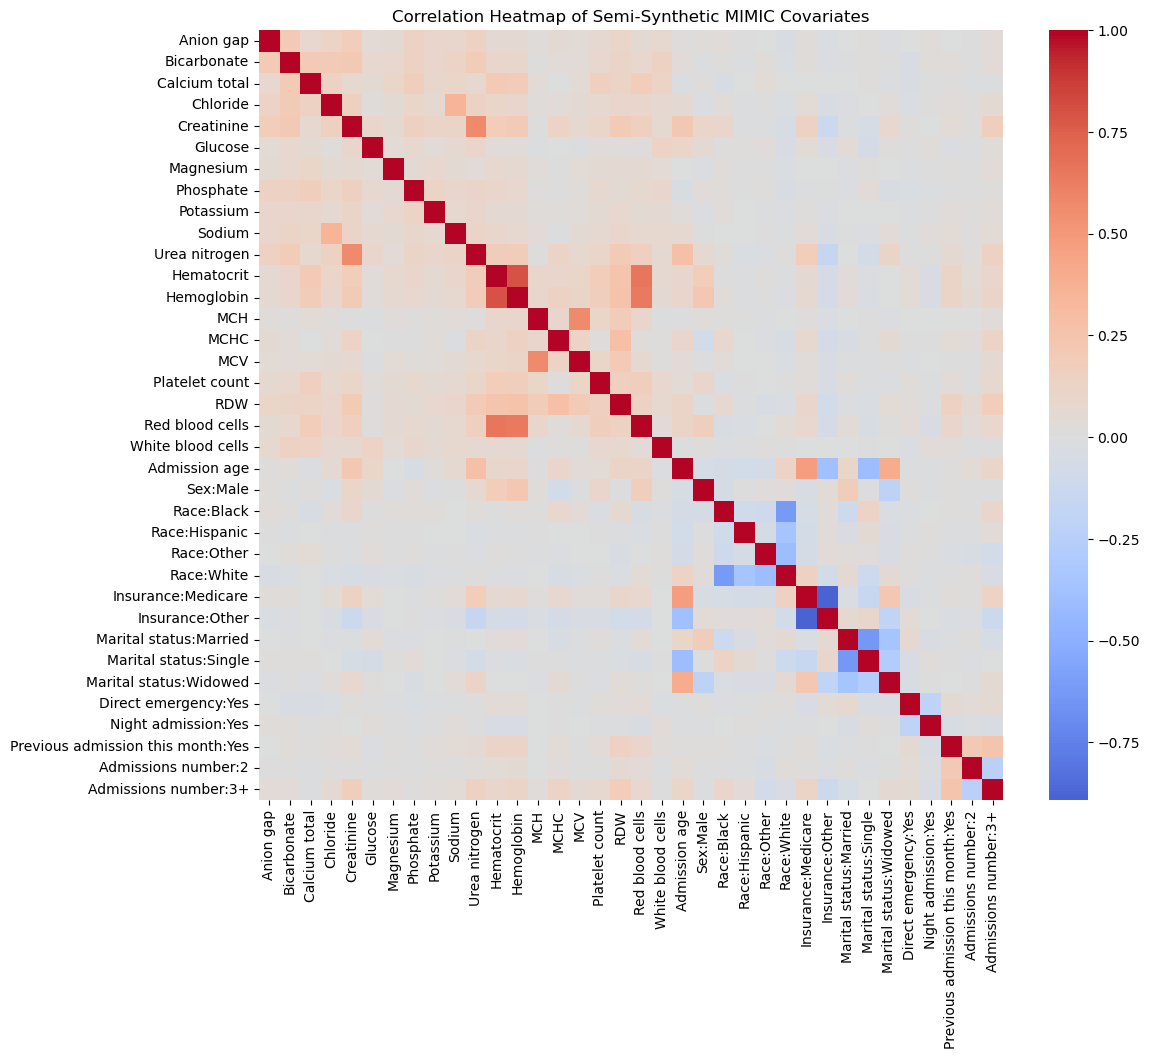

In [41]:
corr = covariates_table.corr(numeric_only=True)
corr.shape  # just to confirm size

corr = corr.iloc[:36, :36]
# heatmap of corr
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Semi-Synthetic MIMIC Covariates')
plt.show()

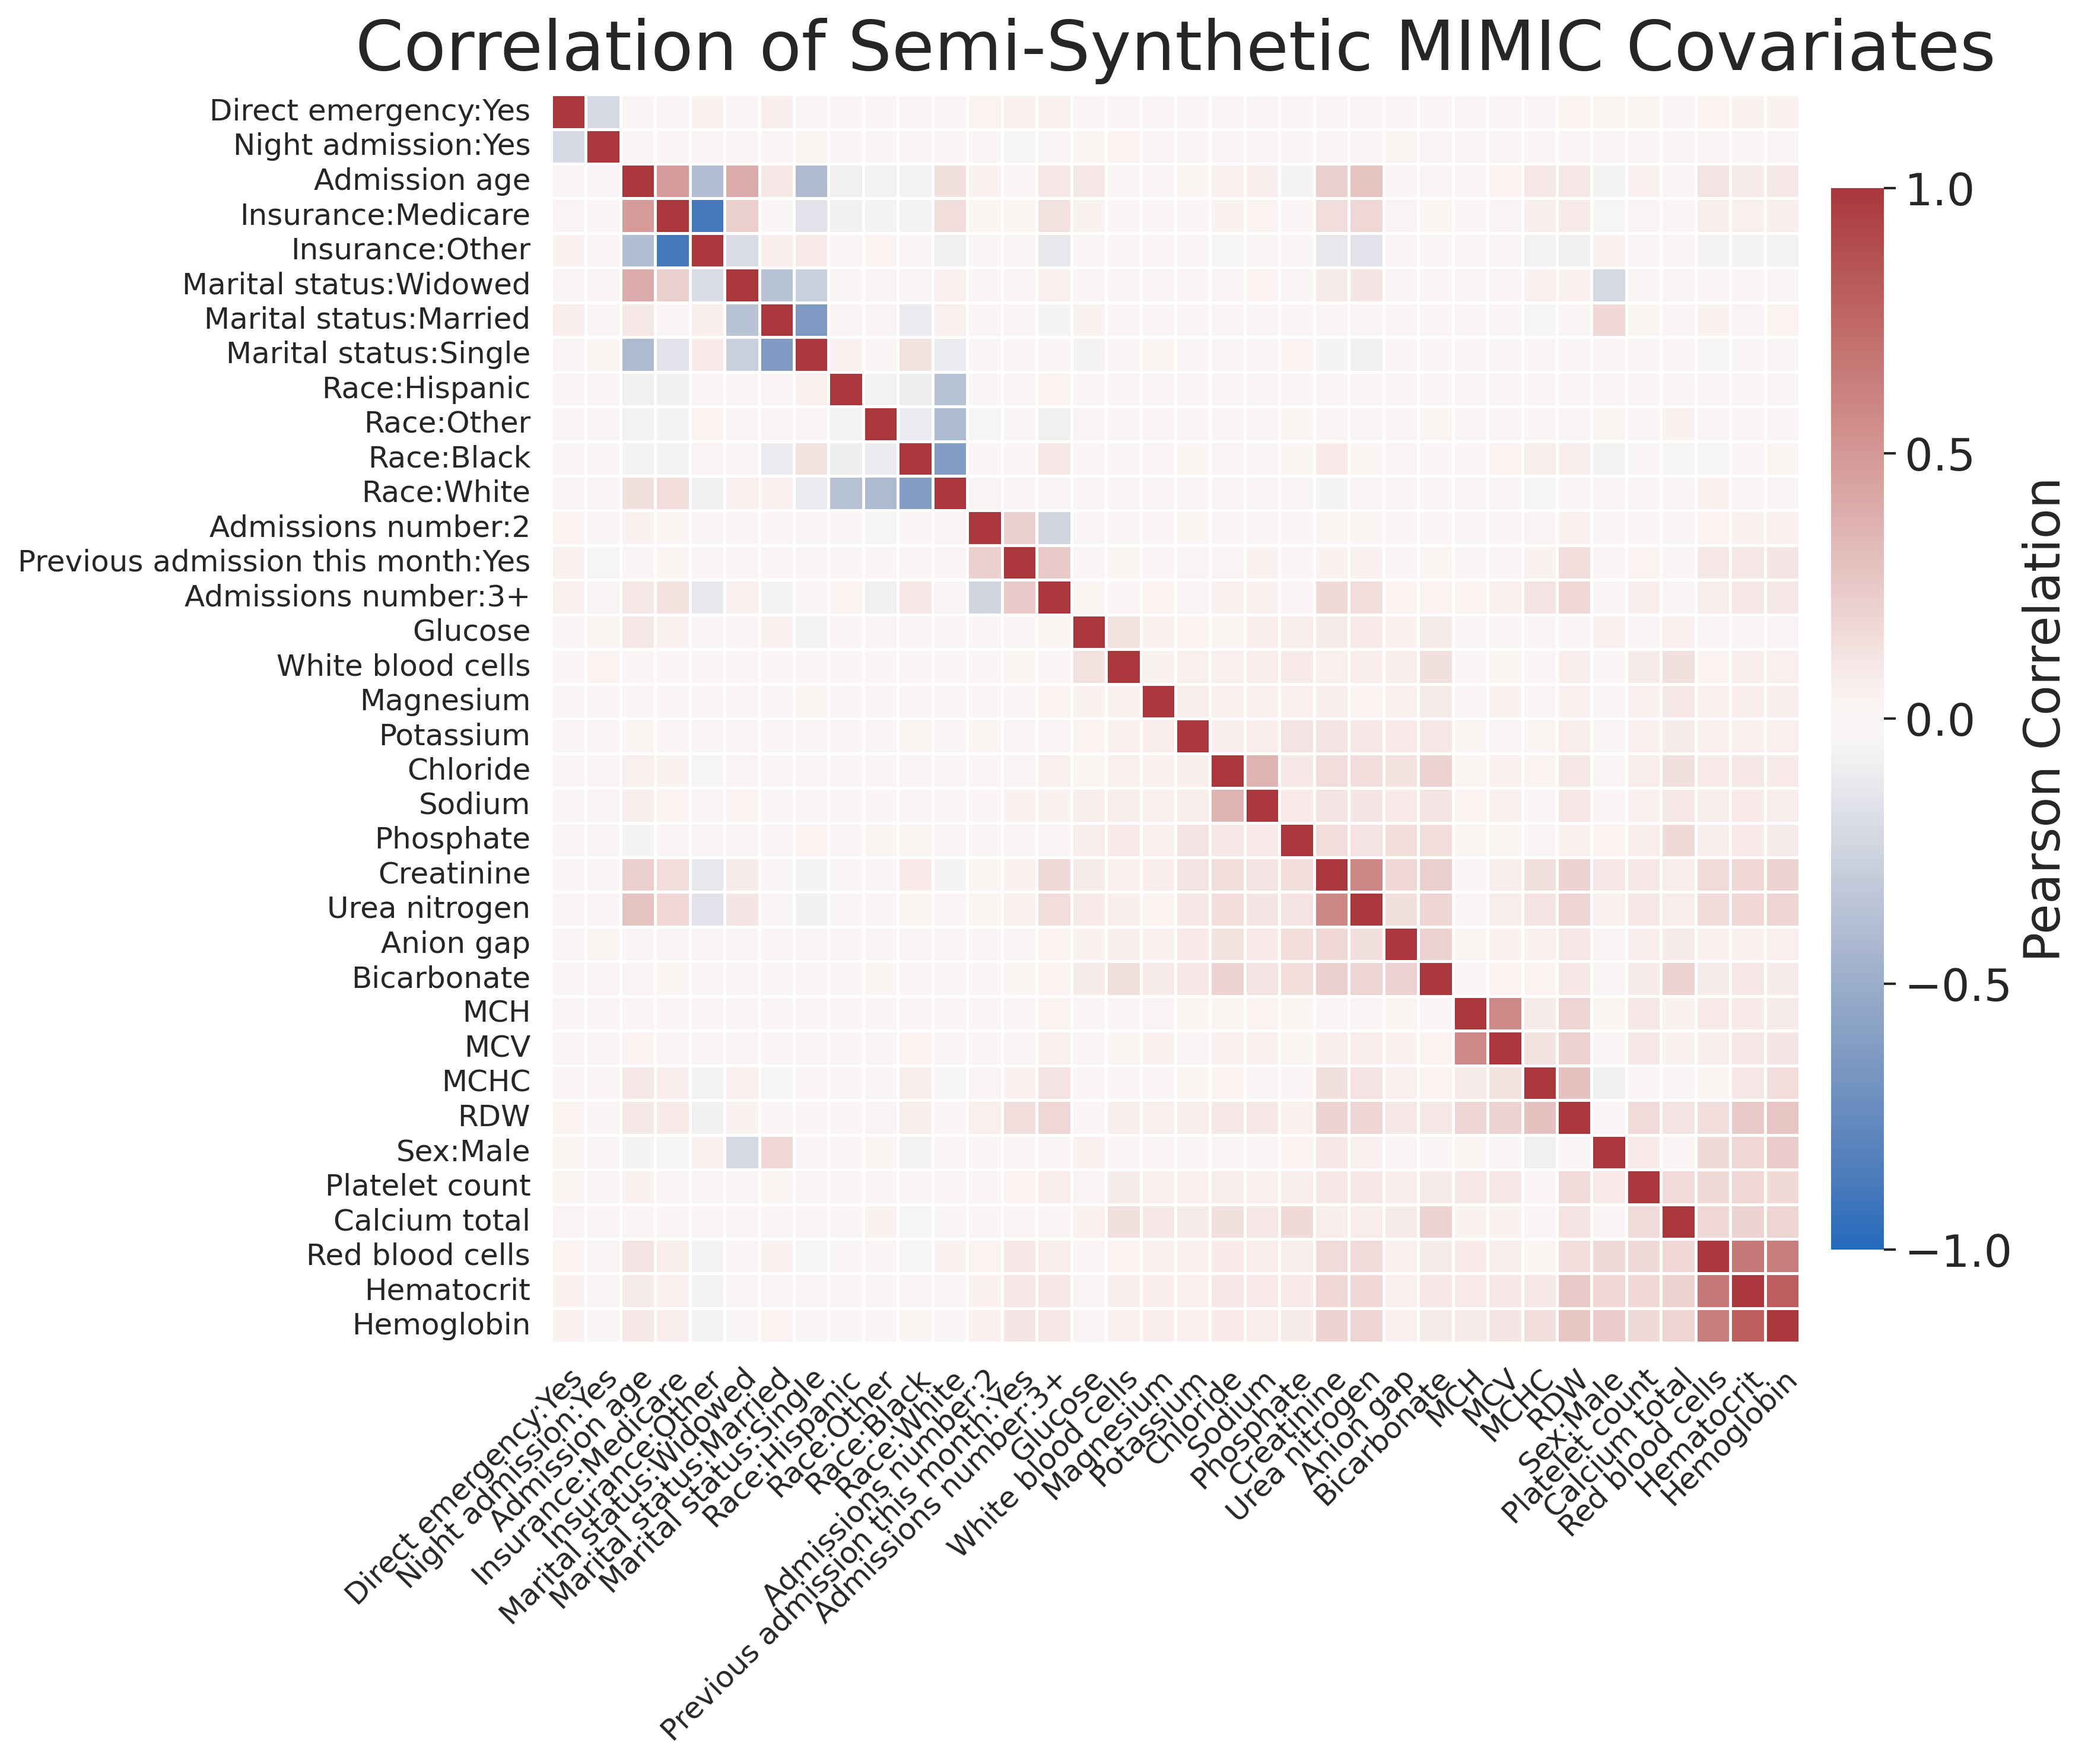

In [75]:
# === Publication-ready correlation heatmap (ICLR style) ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, leaves_list

# ---- Compute & subset (36x36) ----
corr = covariates_table.corr(numeric_only=True).iloc[:36, :36]

# Drop all-NaN rows/cols if any slipped in
corr = corr.dropna(axis=0, how="all").dropna(axis=1, how="all")

# ---- Order variables by hierarchical clustering on |correlation| ----
# Build a distance matrix = 1 - |corr| (clip to [0, 1]) for clustering
d = 1 - np.abs(corr.values)
np.fill_diagonal(d, 0.0)
d = np.clip(d, 0, 1)

# Convert to condensed form & cluster
Z = linkage(squareform(d, checks=False), method="average")
order = leaves_list(Z)

corr_ord = corr.iloc[order, :].iloc[:, order]

# ---- Plot settings (consistent typography & sizes) ----
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.titlesize": 28,
    "axes.labelsize": 24,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.family": "DejaVu Sans",   # safe default; swap to "Times New Roman" if you prefer
})

sns.set_theme(context="paper", style="white")  # minimalist background

# ---- Mask upper triangle to reduce clutter ----
# mask = np.triu(np.ones_like(corr_ord, dtype=bool), k=1)

# ---- Heatmap ----
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr_ord,
    vmin=-1, vmax=1, center=0,
    cmap=sns.color_palette("vlag", as_cmap=True),
    square=True,
    linewidths=.8,          # ↑ increase spacing between squares
    linecolor="white",       # keep gaps crisp
    cbar=True,
    cbar_kws=dict(
        label="Pearson Correlation",
        shrink=0.85,
        pad=0.02,
        ticks=[-1, -0.5, 0, 0.5, 1],
    ),
)

ax.set_facecolor("white")     # ensure the gap color shows through

# Title & ticks
ax.set_title(
    "Correlation of Semi-Synthetic MIMIC Covariates",
    pad=10,
    fontsize=28
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45, ha="right", rotation_mode="anchor",
    fontsize=12
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    fontsize=12
)

# --- Customize colorbar fonts ---
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)             # tick label size
cbar.set_label("Pearson Correlation", size=20)  # label font size


# Tight layout & spine cleanup
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()

# ---- Save high-quality outputs ----
plt.savefig("corr_heatmap_mimic.pdf", bbox_inches="tight")
plt.savefig("corr_heatmap_mimic.png", bbox_inches="tight")
plt.show()
